# Utils

In [ ]:
!pip install -U quandl numpy pandas requests pandas-datareader DateTime yfinance seaborn scipy numpy-financial

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import numpy_financial as npf
import json
import requests
import yfinance as yf
from statistics import NormalDist
from scipy.optimize import minimize
from scipy import stats
from pandas_datareader import data, wb
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

In [3]:
def calculate_return(annual_return, weights):
    return sum(annual_return * weights.T)

def calculate_volatility(cov_metrix, weights):
    portfolio_variance = np.dot(weights.T, np.dot(cov_metrix, weights))
    #standard deviation (risk of portfolio)
    portfolio_risk = np.sqrt(portfolio_variance)
    return portfolio_risk

def calculate_sharpe_ratio(p_return, p_risk):
    return p_return / p_risk

def neg_sharpe(weights, cov_matrix, annual_returns):
    p_risk = calculate_volatility(cov_matrix, weights)
    p_return = calculate_return(annual_returns, weights)
    return calculate_sharpe_ratio(p_return, p_risk) * -1

def simulate_portfolio_returns(years, annual_payment, initial_investment, p_return, p_risk):
    portfolio_distribution = NormalDist(mu=p_return, sigma=p_risk)
    r_0 = portfolio_distribution.inv_cdf(random.random())
    d = {
        "investment": [initial_investment],
        "return": [portfolio_distribution.inv_cdf(random.random())],
        "balance": [initial_investment + initial_investment * r_0],
    }
    for year in range(years):
        investement = d["balance"][len(d["balance"]) - 1] + annual_payment
        return_this_year = portfolio_distribution.inv_cdf(random.random())
        balance = investement + investement * return_this_year
        d["investment"].append(d["investment"][len(d["investment"]) - 1] + annual_payment)
        d["return"].append(return_this_year)
        d["balance"].append(balance)
    return pd.DataFrame.from_dict(d)

def simulate_ending_balances(n, years, annual_payment, initial_investment, p_return, p_risk):
    result = []
    for i in range(n):
        returns = simulate_portfolio_returns(years, annual_payment, initial_investment, p_return, p_risk)
        ending_balance = returns.iloc[-1:]["balance"]
        result.append(float(ending_balance))
    return np.array(result)

def generate_portfolios(tickers, cov_metrix, annual_returns, num_portfolios):
    num_assets = len(tickers)
    # values = [weights..., volatility, return, sharp_ratio]
    values = []
    for single_portfolio in range(num_portfolios):
        row = []
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        row.extend(weights)
        
        p_risk = calculate_volatility(cov_metrix, weights)
        p_return = calculate_return(annual_returns, weights)
        
        row.append(p_risk)
        row.append(p_return)
        row.append(calculate_sharpe_ratio(p_return, p_risk))
        values.append(row)
        
    headers = tickers.copy()
    headers.extend(['risk', 'return', 'sharpe_ratio'])
    return pd.DataFrame(values, columns=headers)

def get_best_portfolio_optimized(tickers, cov_matrix, annual_returns, fn, method, constraints, bounds):
    opt_results = minimize(
        fn, 
        init_guess,
        method=method,
        bounds=bounds, 
        constraints=constraints,
        args=(cov_matrix, annual_returns),
    )
    opt_weights = opt_results.x
    p_risk = calculate_volatility(cov_matrix, opt_weights)
    p_return = calculate_return(annual_returns, opt_weights)
    sharpe_ratio = calculate_sharpe_ratio(p_return, p_risk)
    
    row = list(opt_weights) + [p_risk, p_return, sharpe_ratio]
    headers = tickers.copy()
    headers.extend(['risk', 'return', 'sharp_ratio'])
    return pd.DataFrame([row], columns=headers)

def remove_prefix(text, prefix):
    if text.startswith(prefix):
        return text[len(prefix):]
    return text

def get_us_treasuries_yield():
    url = "https://quote.cnbc.com/quote-html-webservice/quote.htm"
    params = {
        "noform": "1",
        "partnerId": "2",
        "fund": "1",
        "exthrs": "0",
        "output": "json",
        "symbolType": "issue",
        "symbols": "5093148|5093149|5093150|15183113|5093151|5093158|5093159|19892965|5093160|135058359|5093168",
        "requestMethod": "extended",
    }
    data = requests.get(url, params=params).json()
    result = {
        "symbol": [],
        "last": [],
    }
    
    for q in data["ExtendedQuoteResult"]["ExtendedQuote"]:
        result["symbol"].append(q["QuickQuote"]["symbol"])
        result["last"].append(q["QuickQuote"]["last"])
    return pd.DataFrame.from_dict(result)

# Inputs

**tickers** - list of tickers in your portfolio

**asset_type** - type of asset asociated with ticker

**positions** - number of positions for each asset in your portfolio

**historical_data_years** - number of years to fetch the historical data for

**investment_years** - number of years to use for portfolio future value simulation

**annual_payment** - annual payment that you're planning to invest during your **investment_years** period

**initial_investment** - amount of money you're planning to start your investment with

**simulations_number** - number of simulations to use in portfolio optimisation

In [4]:
# Portfolio inputs:
tickers = ['IVV', 'AGG', 'VGT', 'VWOB', 'MSFT']
asset_class = ['stock', 'bond', 'stock', 'bond', 'stock']
positions = [35, 29, 10, 20, 1]
historical_data_years = 10

# Project portfolio for 30 years from now
investment_years = 30
annual_payment = 1000
initial_investment = 10000

simulations_number = 100000
np.random.seed(123)

# Some dynamic input
treasury_bills_yield = get_us_treasuries_yield()
risk_free_rate = float(treasury_bills_yield.iloc[-1]["last"]) / 100
live_prices = yf.download(tickers=tickers, period='1d', interval='1d')
live_prices = [live_prices['Adj Close'][ticker][0] for ticker in tickers]

print("US Treasuries Yield:\n")
print(treasury_bills_yield)
print("\n30 years US treasuries yield used as risk free rate: ", risk_free_rate)

[*********************100%***********************]  5 of 5 completed
US Treasuries Yield:

   symbol   last
0    US1M  0.041
1    US3M  0.236
2    US6M  0.557
3    US1Y   0.88
4    US2Y  1.316
5    US3Y   1.54
6    US5Y  1.773
7    US7Y  1.892
8   US10Y  1.916
9   US20Y  2.277
10  US30Y  2.213

30 years US treasuries yield used as risk free rate:  0.02213


# Basic info

In this section we will see what are the weight of each asset and what balance between asset classes portfolio has

In [27]:
pf = pd.DataFrame.from_dict({'tickers': tickers, 'asset_class': asset_class, 'live_prices': live_prices, 'positions': positions})
pf['value'] = pf['live_prices'] * pf['positions']
pf['weight'] = pf['value'] / pf['value'].sum()
pf.style.format({'live_prices': '{:,.2f}'.format, 'value': '{:,.2f}'.format, 'weight': '{:,.2%}'.format})

,tickers,asset_class,live_prices,positions,value,weight
0,IVV,stock,452.12,35,"15,824.20",63.12%
1,AGG,bond,111.62,29,"3,237.12",12.91%
2,VGT,stock,420.14,10,"4,201.45",16.76%
3,VWOB,bond,74.99,20,"1,499.78",5.98%
4,MSFT,stock,305.83,1,305.83,1.22%


In [28]:
print('Allocation by class:')
pf.groupby(['asset_class']) \
    .sum().drop(columns=['live_prices', 'value', 'positions']) \
    .style.format({'weight': '{:,.2%}'.format})

Allocation by class:


,weight
asset_class,
bond,18.90%
stock,81.10%


# Historical data

In this section we retrieve historical data for each asset for the period of **historical_data_years** and calculate basic statistics.

In [29]:
start = datetime.now() - timedelta(days = 365 * historical_data_years)
end = datetime.now()
print('Start date:', start.strftime("%d/%m/%Y"), 'End date:', end.strftime("%d/%m/%Y"))

Start date: 04/02/2012 End date: 01/02/2022


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,tickers,starting_date,observations(days),annual_return,variance,std
0,IVV,02/06/2012,2515,15.40%,2.69%,16.41%
1,AGG,02/06/2012,2515,2.58%,0.16%,4.00%
2,VGT,02/06/2012,2515,21.37%,4.20%,20.50%
3,VWOB,06/04/2013,2183,3.94%,0.66%,8.12%
4,MSFT,02/06/2012,2515,28.60%,6.53%,25.55%


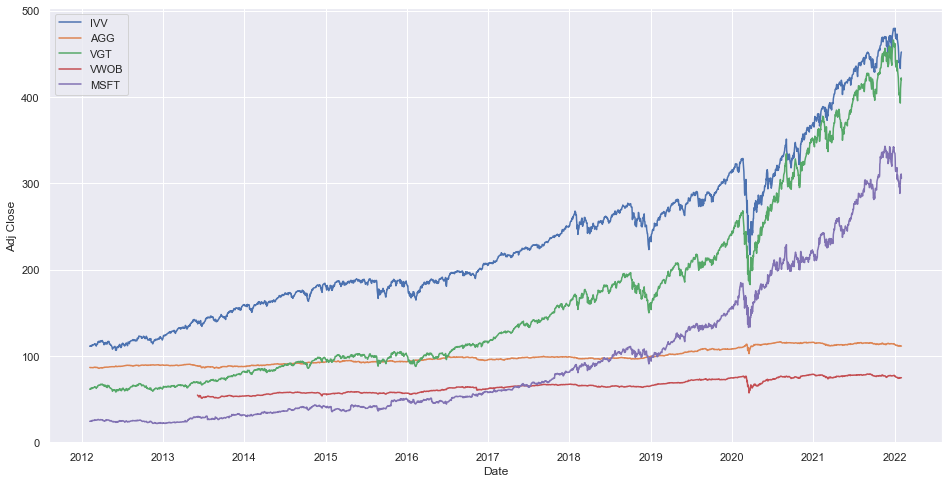

In [30]:
stock_info = {'tickers': tickers, 'starting_date': [], 'observations(days)': [], 'annual_return': [], 'variance': []}
price_hist = {}

sns.set(rc = {'figure.figsize': (16,8)})

for ticker in tickers:
    tmp = yf.download(ticker, start=start, end=end)
    tmp['daily_change'] = tmp['Adj Close'].pct_change()
    stock_info['starting_date'].append(tmp.index[0])
    stock_info['annual_return'].append(tmp['daily_change'].mean() * 252)
    stock_info['variance'].append(tmp['daily_change'].var() * 252)
    stock_info['observations(days)'].append(len(tmp))
    price_hist[ticker] = tmp['daily_change']
    sns.lineplot(x=tmp.index, y='Adj Close', data=tmp, markers=True, label=ticker)
    
price_hist = pd.DataFrame.from_dict(price_hist)

df = pd.DataFrame.from_dict(stock_info)
df['std'] = df['variance'].apply(np.sqrt)
df['starting_date'] = df['starting_date'].dt.strftime('%m/%d/%Y')
df.style.format({'annual_return': '{:,.2%}'.format, 'variance': '{:,.2%}'.format, 'std': '{:,.2%}'.format})

# Correlation among portfolio assets

Text(0.5, 1.0, 'Portfolio Pearson correlation')

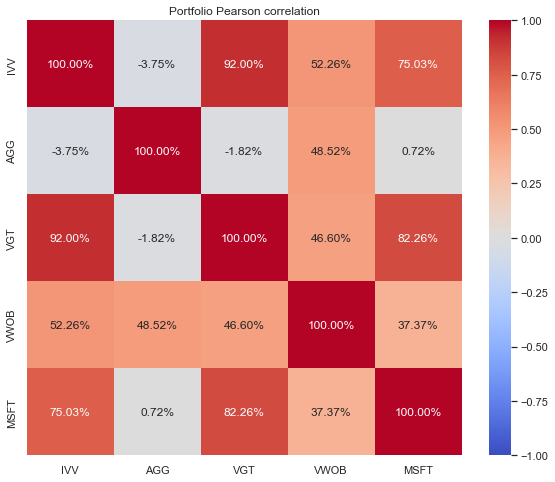

In [31]:
sns.set(rc = {'figure.figsize': (10, 8)})
sns.heatmap(
    price_hist.corr(method='pearson'), 
    annot=True, 
    square=True, 
    fmt=".2%", 
    cmap=sns.color_palette("coolwarm", as_cmap=True),
    vmin=-1, vmax=1
).set_title('Portfolio Pearson correlation')

# Caculate risk and return of the portfolio based on historical data

In [32]:
p_return = calculate_return(df['annual_return'].to_numpy(), pf['weight'].to_numpy())
p_risk = calculate_volatility((price_hist.cov() * 252).to_numpy(), pf['weight'].to_numpy())
print(
    "Portfolio_return:", "{0:.2f}%".format(p_return * 100), 
    "\nPortfolio_risk:", "{0:.2f}%".format(p_risk * 100),
    "\nSharpe ratio:", "{0:.2f}".format(calculate_sharpe_ratio(p_return, p_risk)),
)

Portfolio_return: 14.22% 
Portfolio_risk: 14.10% 
Sharpe ratio: 1.01


# PV&FV + Confidence intervals

Let's calculate the present and future value of portfolio based on **simulations_number** of portfolio return simulations.

Additionally we will try to guess how much money we will end up with and how sure we are about it.

In [16]:
ending_balances = simulate_ending_balances(
    simulations_number, 
    investment_years, 
    annual_payment, 
    initial_investment, 
    p_return, 
    p_risk,
)
get_percentile_fv_and_pv = lambda balances, rate, years, percentile: [
        np.percentile(balances, percentile), 
        npf.pv(rate, years, 0, fv=-np.percentile(balances, percentile))
]

print(
    "Your total investment over %d years is %d" % 
    (investment_years, initial_investment + annual_payment * investment_years)
)
print(
    "\nEndingBalance_Mean(FV):", "{0:.2f}".format(ending_balances.mean()), 
    "\nEndingBalance_Mean(PV):", "{0:.2f}".format(npf.pv(risk_free_rate, investment_years, 0, fv=-ending_balances.mean())),
)
print("\nWith confidence of [col_name_here] you'll end up with: ")
pd.DataFrame.from_dict({
    "99%": get_percentile_fv_and_pv(ending_balances, risk_free_rate, investment_years, 1),
    "95%": get_percentile_fv_and_pv(ending_balances, risk_free_rate, investment_years, 5),
    "90%": get_percentile_fv_and_pv(ending_balances, risk_free_rate, investment_years, 10),
    "80%": get_percentile_fv_and_pv(ending_balances, risk_free_rate, investment_years, 20),
    "50%": get_percentile_fv_and_pv(ending_balances, risk_free_rate, investment_years, 50),
    "20%": get_percentile_fv_and_pv(ending_balances, risk_free_rate, investment_years, 80),
}).set_index([pd.Index(['FV', 'PV'])])

Your total investment over 30 years is 40000

EndingBalance_Mean(FV): 785582.35 
EndingBalance_Mean(PV): 433697.15

With confidence of [col_name_here] you'll end up with: 


,99%,95%,90%,80%,50%,20%
FV,166954.144941,249221.411941,308604.142639,401102.714141,660223.944059,1.085847e+06
PV,92170.523216,137587.886443,170371.363369,221437.131968,364490.419722,5.994647e+05


# [Efficient Frontier](https://www.investopedia.com/terms/e/efficientfrontier.asp)

## Searching for best portfolio

Lets find best portfolio generating different combinations of weights for assets. Number of simulated portfolios is **simulations_number**. The best portfolio has the biggest [Sharpe ratio](https://www.investopedia.com/terms/s/sharperatio.asp)

In [17]:
rand_portfolios = generate_portfolios(
    tickers, 
    (price_hist.cov() * 252).to_numpy(), 
    df['annual_return'].to_numpy(), 
    simulations_number,
)
best_portfolio = rand_portfolios.iloc[[rand_portfolios['sharpe_ratio'].argmax()]]
print("Best portfolio:\n")
pd.DataFrame(best_portfolio).round(decimals=3)

Best portfolio:



,IVV,AGG,VGT,VWOB,risk,return,sharpe_ratio
75443,0.025,0.767,0.207,0.001,0.055,0.068,1.235


## Optimize by [Sharpe ratio](https://www.investopedia.com/terms/s/sharperatio.asp)

In [18]:
cons = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)-1})
bounds = [(0, 1) for ticker in tickers]
init_guess = [0.25 for ticker in tickers]

print("Best portfolio optimized:\n")
best_portfolio_optimized = get_best_portfolio_optimized(
    tickers, 
    (price_hist.cov() * 252).to_numpy(), 
    df['annual_return'].to_numpy(),
    neg_sharpe,
    'SLSQP',
    cons,
    bounds
).round(decimals=3)
best_portfolio_optimized

Best portfolio optimized:



,IVV,AGG,VGT,VWOB,risk,return,sharp_ratio
0,0.0,0.763,0.237,0.0,0.057,0.07,1.237


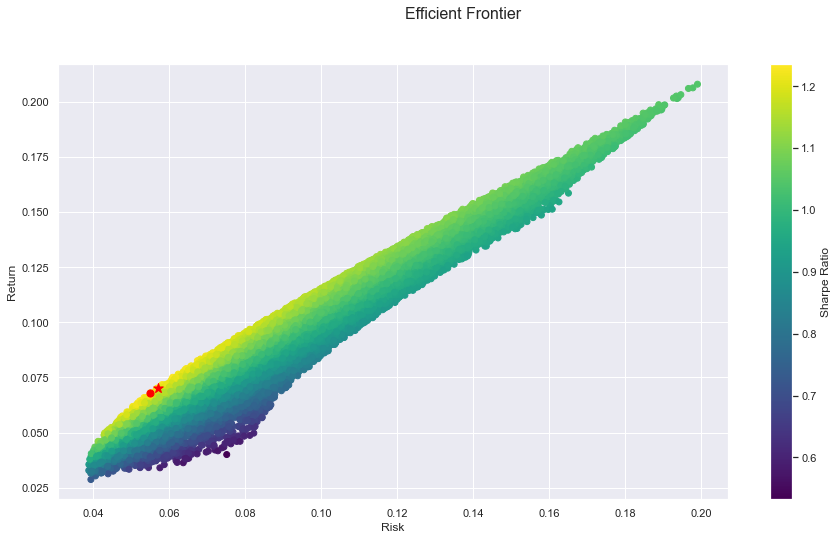

In [19]:
fig = plt.figure(figsize=(15,8))
fig.suptitle('Efficient Frontier', fontsize=16)
plt.scatter(rand_portfolios['risk'], rand_portfolios['return'], c=rand_portfolios['sharpe_ratio'], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.scatter(best_portfolio['risk'], best_portfolio['return'], c='red', s=50) # red dot
plt.scatter(best_portfolio_optimized['risk'], best_portfolio_optimized['return'], c='red', s=100, marker='*') # red star
plt.show()

# References
https://codingandfun.com/portfolio-risk-and-returns-python/

https://www.investopedia.com/ask/answers/041515/what-difference-between-variance-and-covariance.asp

https://www.investopedia.com/terms/c/correlationcoefficient.asp

https://www.investopedia.com/ask/answers/041315/how-covariance-used-portfolio-theory.asp

https://towardsdatascience.com/how-to-construct-an-efficient-portfolio-using-the-modern-portfolio-theory-in-python-5c5ba2b0cff4

https://medium.com/@luo9137/how-to-generate-these-popular-stock-terms-using-python-4e69c6acc6b3

https://amangupta16.medium.com/portfolio-optimization-using-python-part-1-2-9fd80097a606

https://medium.com/python-data/effient-frontier-in-python-34b0c3043314

https://towardsdatascience.com/python-markowitz-optimization-b5e1623060f5